# Script to Plot Daily Temperature Anomalies for IMOS Buoys

The script accesses IMOS buoy temperature files using direct s3 access, combines the different daily files, calculates the anomalies, and plots them. The first portion of the data is modified from IMOS_plot_rottnest.ipynb

## Import Packages

In [1]:
#import packages
import fsspec
from fsspec.core import url_to_fs
import numpy as np
from dask.distributed import Client
import s3fs
import xarray as xr
from dask import bag as db
import matplotlib.pyplot as plt


## Load Data

In [2]:
#load all files from a buoy folder
fs = fsspec.filesystem('s3',use_listings_cache=False,anon=True,)

ref_files = fs.glob('s3::imos-data/IMOS/ANMN/NSW/CH100/Temperature/*.nc')
ref_files[0:5]

['imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20090812T020004Z_CH100_FV01_CH100-0908-Aqualogger-520PT-99.5_END-20091001T145004Z_C-20160824T072817Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20091214T020000Z_CH100_FV01_CH100-0912-Aqualogger-520T-28.5_END-20100226T023000Z_C-20160824T073255Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20091214T020000Z_CH100_FV01_CH100-0912-Aqualogger-520T-36.5_END-20100226T020000Z_C-20160824T073254Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20091214T020000Z_CH100_FV01_CH100-0912-Aqualogger-520T-44.5_END-20100226T013000Z_C-20160824T073254Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20091214T020000Z_CH100_FV01_CH100-0912-Aqualogger-520T-60.5_END-20100226T005500Z_C-20160824T073254Z.nc']

In [3]:
#sort all files
ref_files = np.sort(ref_files)

#extract the unique file ID
files = [ref_files[i].split('/')[6].split('-')[2] for i in range(len(ref_files))]
files = np.unique(files)

#create an empty list
first_ref_files = []

#loop through eacy unique file ID
for i in range(len(files)):
    
    #filter all the files with that ID
    filtered_list = filter(lambda file: file.split('/')[6].split('-')[2] == files[i], ref_files)
    filtered_list = sorted(filtered_list)
    #select just the first one
    first = next(iter(filtered_list), None)
    #add file name to list
    first_ref_files.append(first)
    
first_ref_files[0:5]

['imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20090812T020004Z_CH100_FV01_CH100-0908-Aqualogger-520PT-99.5_END-20091001T145004Z_C-20160824T072817Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20091214T020000Z_CH100_FV01_CH100-0912-Aqualogger-520T-28.5_END-20100226T023000Z_C-20160824T073255Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20100211T230000Z_CH100_FV01_CH100-1002-Aqualogger-520PT-96.9_END-20100420T014000Z_C-20160824T074045Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20100407T010000Z_CH100_FV01_CH100-1004-Aqualogger-520PT-37_END-20100524T222000Z_C-20160824T074709Z.nc',
 'imos-data/IMOS/ANMN/NSW/CH100/Temperature/IMOS_ANMN-NSW_TZ_20100504T230000Z_CH100_FV01_CH100-1005-Aqualogger-520PT-97.4_END-20100706T010000Z_C-20160824T075051Z.nc']

In [4]:
#instantiate dask client
client = Client(n_workers=16,threads_per_worker=16) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/gkoval11/proxy/8787/status,
Dashboard: /user/gkoval11/proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36695,Workers: 16
Dashboard: /user/gkoval11/proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:39021,Total threads: 16
Dashboard: /user/gkoval11/proxy/35081/status,Memory: 512.00 MiB
Nanny: tcp://127.0.0.1:44645,


In [5]:
#create function to open file
def open_cdt(url):
    s3 = s3fs.S3FileSystem(anon=True,default_fill_cache=False,default_cache_type=None)
    with s3.open(url,) as f:
        data=xr.open_dataset(f,engine='h5netcdf').load().squeeze()
        data['TEMP'] = data['TEMP'][data.TEMP_quality_control==1]
    return data


#loop through and open all files
b = db.from_sequence(first_ref_files)
cast = db.map(open_cdt,b).compute()

In [6]:
#join the files based on shared coordinates
commonvars = list(set.intersection(*list((map(lambda x:set([i for i in x.data_vars]),cast)))))
cast = [ds[commonvars] for ds in cast]

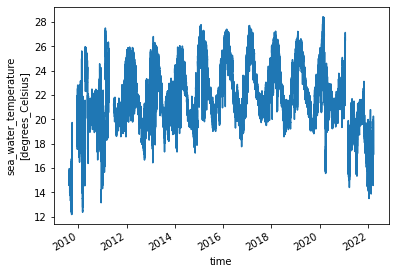

In [7]:
#combine all files into one
c =xr.concat(cast,dim='TIME')
c.TEMP.plot(x = 'TIME')

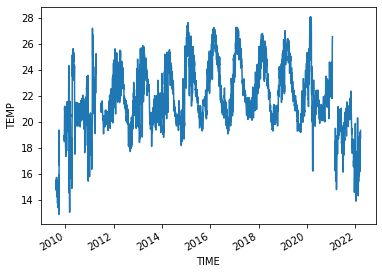

In [8]:
#resample to calculate daily means
c_day = c.sortby(c.TIME).resample(TIME = 'D').mean()
c_day.TEMP.plot(x = 'TIME')

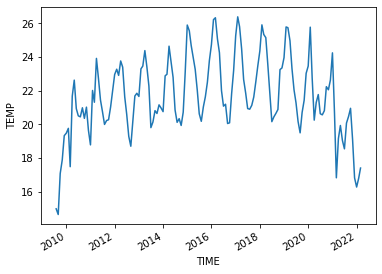

In [9]:
#interpolate the missing data
c_inter = c_day.interpolate_na(dim=('TIME'), method='linear')
#resample to calculate the monthly means
c_month = c_inter.resample(TIME = 'MS').mean()
c_month.TEMP.plot(x = "TIME")

## Anomalies

In [10]:
# Calculate the climatology
c_clim_mean = c_inter.TEMP.groupby('TIME.month').mean('TIME',keep_attrs=True,skipna=True) 
c_clim_std = c_inter.TEMP.groupby('TIME.month').std('TIME',keep_attrs=True,skipna=True) 

# creates a dataset with climatology and standard deviaton 
ds = xr.Dataset({'clim':c_clim_mean,'+Std':c_clim_mean+c_clim_std,'-Std':c_clim_mean-c_clim_std}) # add standard deviation time series +/-

# calculate the anomalies
c_anom = c_inter.TEMP.groupby('TIME.month') - c_clim_mean 
c_anom_monthly = c_anom.resample(TIME ='1MS', loffset='15D').mean(keep_attrs=True, skipna=True) # calculate monthly anomalies/smoothing
c_anom

<xarray.DataArray 'TEMP' (TIME: 4615)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2009-08-12 2009-08-13 ... 2022-03-31
    month    (TIME) int64 8 8 8 8 8 8 8 8 8 8 8 8 8 ... 3 3 3 3 3 3 3 3 3 3 3 3

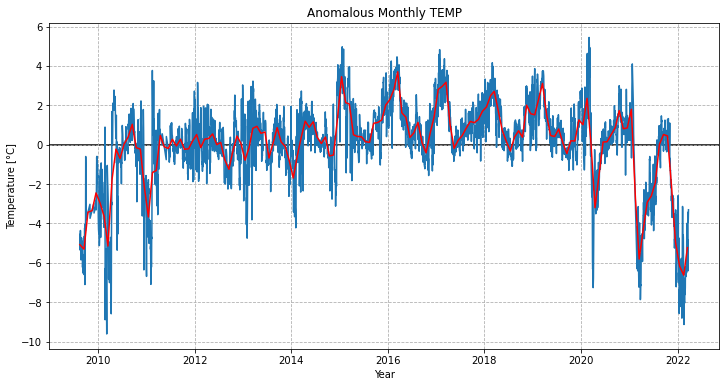

In [11]:
#create figure
plt.figure(figsize = [12, 6]) 
plt.plot(c_anom.TIME,c_anom, zorder = 2)
plt.plot(c_anom_monthly.TIME, c_anom_monthly, zorder = 3, c = 'r')
plt.axhline(0, c = 'k', zorder = 1)
plt.xlabel('Year')
plt.ylabel('Temperature [°C]')
plt.title('Anomalous Monthly TEMP')
plt.grid(linestyle = '--')

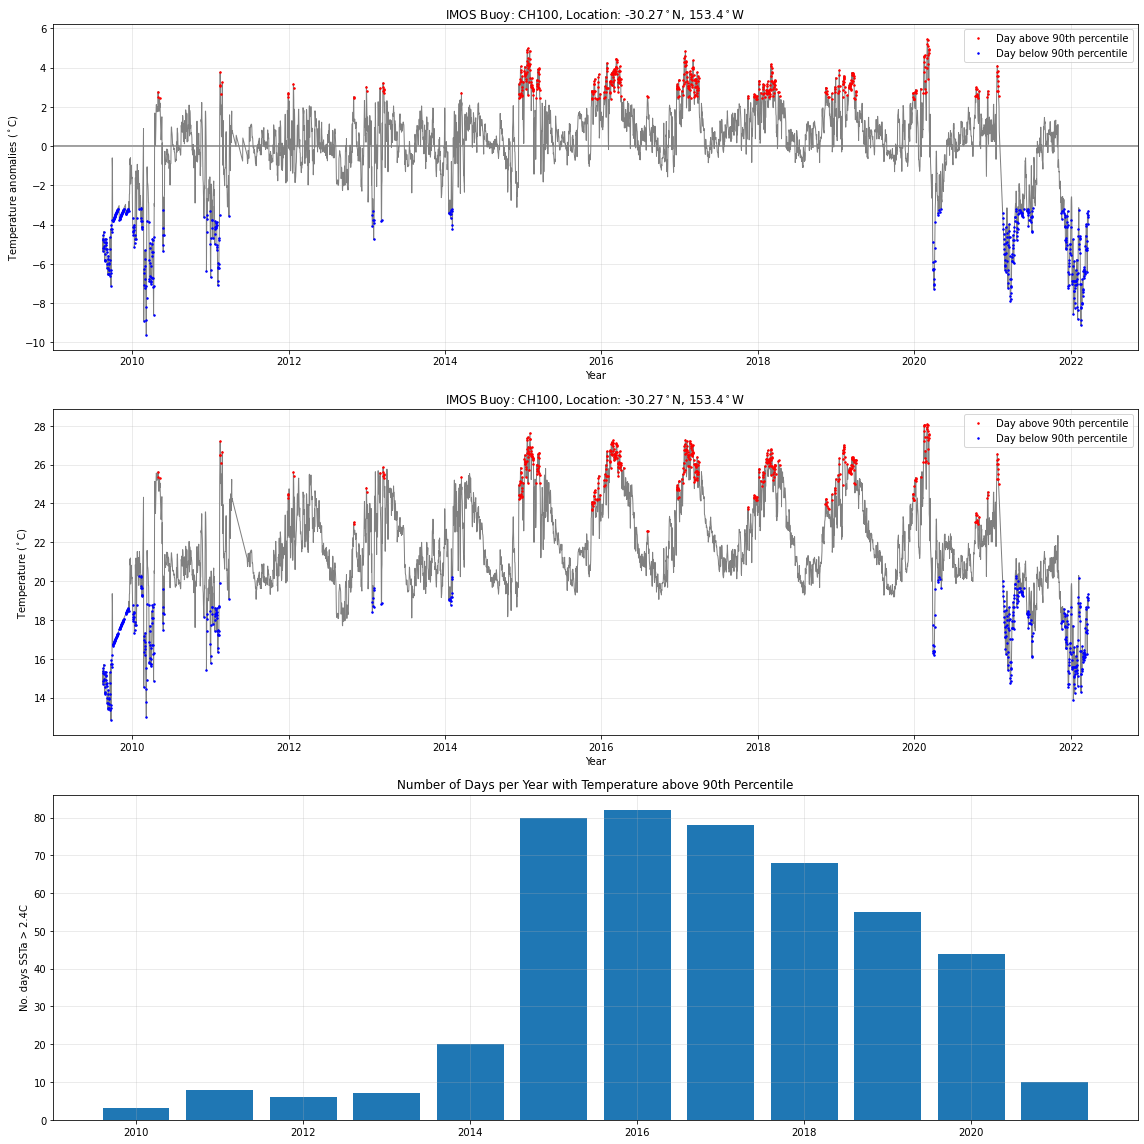

In [12]:
# first, calculate the threshold: 90th percentile
thr_plus = np.percentile(c_anom.where(~np.isnan(c_anom), drop = True), 90)
thr_min = np.percentile(c_anom.where(~np.isnan(c_anom), drop = True), 10)

#create a 3 vertical panel figure
fig, axs = plt.subplots(3,1,figsize=(16,16)) 

#create plot of anaomaly data
plt.subplot(3,1,1) 
plt.plot(c_anom.TIME,c_anom, lw=1, c = 'grey')
plt.axhline(y=0, c='k', zorder=0, alpha=0.5) # add a line to highlight the x axis 
a=c_anom>=thr_plus # select data above the threshold
plt.plot(c_anom.TIME[a], c_anom[a],'.r', markersize=3, label = 'Day above 90th percentile')
b=c_anom<=thr_min # select data above the threshold
plt.plot(c_anom.TIME[b], c_anom[b],'.b', markersize=3, label = 'Day below 90th percentile')
# all stuff here to make it look good
plt.ylabel('Temperature anomalies ($^\circ$C)')
plt.xlabel('Year')
plt.title('IMOS Buoy: ' + c.attrs['site_code'] + ', Location: '+str(np.around(c.LATITUDE.mean().values, 2))+'$^\circ$N, '+str(np.around(c.LONGITUDE.mean().values, 2))+'$^\circ$W')
plt.grid(True, alpha=0.3)
plt.legend()

# Now plot on the original data (not anomalies)
plt.subplot(3,1,2) # second panel
plt.plot(c_inter.TIME,c_inter.TEMP, lw=1, c = 'grey')
plt.plot(c_inter.TIME[a], c_inter.TEMP[a],'.r', markersize=3, label = 'Day above 90th percentile') # plot only the values equal or above threshold
plt.plot(c_inter.TIME[b], c_inter.TEMP[b],'.b', markersize=3, label = 'Day below 90th percentile') # plot only the values equal or above threshold
# all stuff here to make it look good
plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Year')
plt.title('IMOS Buoy: ' + c.attrs['site_code'] + ', Location: '+str(np.around(c.LATITUDE.mean().values, 2))+'$^\circ$N, '+str(np.around(c.LONGITUDE.mean().values, 2))+'$^\circ$W')
plt.grid(True, alpha=0.3)
plt.legend()

# plot number of hot days per year
dts = c_anom[c_anom>=thr_plus].TIME
mhw = dts.groupby('TIME.year').count()
plt.subplot(3,1,3) # third panel
plt.bar(mhw.year,mhw)
plt.ylabel('No. days SSTa > '+str(np.round(thr_plus,1))+'C')
plt.title('Number of Days per Year with Temperature above 90th Percentile')
plt.grid(True, alpha=0.3)
plt.tight_layout()

#plt.savefig('/home/jovyan/IMOS_Buoy' + c.attrs['site_code'] + '_anomalies.jpg')
plt.show()